# Image Segmentation using Gaussian Mixture Models (GMM)

This notebook demonstrates image segmentation using Gaussian Mixture Models (GMM). The workflow includes loading an image, normalizing pixel values, initializing GMM parameters with K-Means, running the Expectation-Maximization (EM) algorithm, and visualizing the segmented output.

## Workflow Overview
1. **Import Libraries**: Load required Python libraries and utility functions.
2. **GMM Class**: Define the GMM class with inference (E-step) and update (M-step) methods.
3. **Image Loading & Preprocessing**: Load the image and normalize pixel values.
4. **K-Means Initialization**: Use K-Means to initialize GMM parameters.
5. **EM Algorithm**: Iteratively update GMM parameters until convergence.
6. **Segmentation Visualization**: Display the segmented image using the trained GMM.

In [1]:
import numpy as np
from utils.utils import COLORS, load_image
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


## 1. Import Required Libraries
Import all necessary libraries for image processing, clustering, and visualization. Also, import utility functions and color definitions from the `utils` module.

In [2]:
class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas): # E-step
        unnormalized_probs = [] 
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            unnormalized_prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        preds = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(preds, axis=1)
        log_likelihood = np.sum(np.log(log_likelihood))

        preds = preds / np.sum(preds, axis=1, keepdims=True)
        return np.asarray(preds), log_likelihood

    def update(self, datas, beliefs): # M-step
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(beliefs, axis=0)
        for i in range(self.ncomp):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)

            data_shifted = np.subtract(datas, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1), data_shifted)), data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)

            new_priors.append(soft_counts[i] / np.sum(soft_counts))

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)


## 2. Gaussian Mixture Model (GMM) Class
This section defines the `GMM` class, which implements the Expectation-Maximization (EM) algorithm for clustering image pixels. The class includes:
- **Initialization**: Set the number of components, means, covariances, and priors.
- **E-step (inference)**: Compute the probability (belief) of each pixel belonging to each component.
- **M-step (update)**: Update the parameters based on the computed beliefs.

In [3]:
# Load image
image_name = input('Input the image name: ')
image_path = f'images/{image_name}.jpg'
image = load_image(image_path)
image_height, image_width, image_channels = image.shape
image_pixels = np.reshape(image, (-1, image_channels))

# Normalization
_mean = np.mean(image_pixels, axis=0, keepdims=True)
_std = np.std(image_pixels, axis=0, keepdims=True)
image_pixels = (image_pixels - _mean) / _std


## 3. Load and Normalize Image
Load the target image, extract its pixel data, and normalize the pixel values to have zero mean and unit variance. This preprocessing step helps improve clustering performance.

In [4]:
# Input number of classes
ncomp = int(input('Input number of classes: '))

# Apply K-Means for initialization
kmeans = KMeans(n_clusters=ncomp)
labels = kmeans.fit_predict(image_pixels)
initial_mus = kmeans.cluster_centers_
initial_priors, initial_covs = [], []

for i in range(ncomp):
    datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
    initial_covs.append(np.cov(datas))
    initial_priors.append(datas.shape[1] / float(len(labels)))

# Initialize GMM
gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)


## 4. K-Means Initialization and GMM Setup
Use K-Means clustering to initialize the means, covariances, and priors for the GMM. This provides a good starting point for the EM algorithm. Then, create a GMM instance with these initial parameters.

In [5]:
prev_log_likelihood = None
for i in range(1000):
    beliefs, log_likelihood = gmm.inference(image_pixels) # E-step
    gmm.update(image_pixels, beliefs)   # M-step
    print(f'Iteration {i+1}: Log Likelihood = {log_likelihood}')
    if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood


Iteration 1: Log Likelihood = -455441.53237431706
Iteration 2: Log Likelihood = -347139.3755224135
Iteration 3: Log Likelihood = -255886.96045903943
Iteration 4: Log Likelihood = -195128.77992568118
Iteration 5: Log Likelihood = -186904.7951116951
Iteration 6: Log Likelihood = -184280.35882993723
Iteration 7: Log Likelihood = -183060.3875049447
Iteration 8: Log Likelihood = -182428.64229259914
Iteration 9: Log Likelihood = -182087.90786411765
Iteration 10: Log Likelihood = -181899.44794955867
Iteration 11: Log Likelihood = -181793.2665974298
Iteration 12: Log Likelihood = -181732.5717187041
Iteration 13: Log Likelihood = -181697.47156036037
Iteration 14: Log Likelihood = -181676.98039142173
Iteration 15: Log Likelihood = -181664.9260285009
Iteration 16: Log Likelihood = -181657.79101223452
Iteration 17: Log Likelihood = -181653.54691148963
Iteration 18: Log Likelihood = -181651.01247935428
Iteration 19: Log Likelihood = -181649.49428664744
Iteration 20: Log Likelihood = -181648.5826105

## 5. Run Expectation-Maximization (EM) Algorithm
Iteratively perform the E-step and M-step to update the GMM parameters. The process continues until the log-likelihood converges, indicating that the model has stabilized.

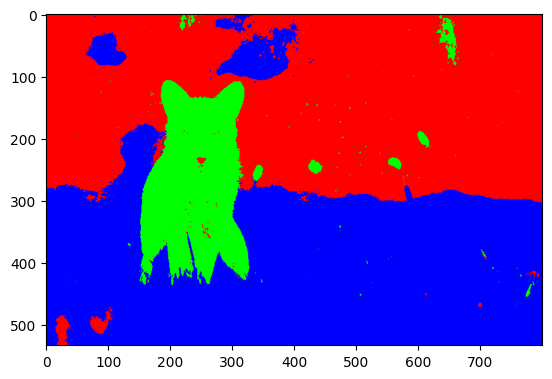

In [6]:
beliefs, log_likelihood = gmm.inference(image_pixels)
map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
segmented_map = np.zeros((image_height, image_width, 3))

for i in range(image_height):
    for j in range(image_width):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0

plt.imshow(segmented_map)
plt.show()


## 6. Visualize Segmented Image
After training the GMM, use the learned parameters to assign each pixel to a segment (class) and visualize the resulting segmented image. Each segment is colored according to a predefined color palette.